In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import re

from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [38]:
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

In [2]:
# 載入數據至Pandas資料表 DataFrame

dfTrain = pd.DataFrame(pd.read_csv("/share/all/train.csv"))
dfTest = pd.DataFrame(pd.read_csv("/share/all/test.csv"))

dfTrain.head(5) # 看資料表前五行

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# 觀察資料

In [3]:
## 將資料內容轉存至共同變數
df = dfTrain.iloc[:, :-1]
df = df.append(dfTest)
target = dfTrain['SalePrice']

In [ ]:
# 觀察欄位名 屬性 非空值筆數
df.info()

In [ ]:
#(資料筆數,欄位數)
df.shape

In [ ]:
# 觀察欄位不重複值
df.apply(lambda x:x.unique().shape[0],axis=0)

In [ ]:
plt.figure(figsize=(12,12),dpi=200)  # 調整圖片尺寸
(df.apply(lambda x:x.unique().shape[0],axis=0)/df.shape[0]).plot(kind='bar');

In [ ]:
# 空值數量
df.isnull().sum()

In [ ]:
# 空值欄位
df.loc[:,pd.Series(df.isnull().any())]

# 資料清理

In [4]:
# 欄位補0或None
c = ["LotFrontage","GarageYrBlt","GarageCars","BsmtFullBath","BsmtUnfSF","BsmtFinSF1","GarageArea",
     "TotalBsmtSF","BsmtFinSF2","BsmtHalfBath"]

df[c] = df[c].fillna(0)

d = ["Alley","BsmtCond","BsmtQual","BsmtExposure","BsmtFinType1","BsmtFinType2","FireplaceQu",
     "GarageType","GarageFinish","GarageQual","GarageCond","KitchenQual"]
df[d] = df[d].fillna('None')

In [5]:
# 特殊欄位補None 原意有值改1? 暫時不變原有資料測試
c = ["PoolQC","Fence"]
df[c] = df[c].fillna('None')

c = ["MiscFeature"]
df[c] = df[c].fillna('None')

In [6]:
# 用眾值填補空值
c = ["MasVnrType","MasVnrArea","Electrical","MSZoning","Utilities","Exterior1st","Exterior2nd","SaleType","Functional"]

for i in c:
    df[i] = df[i].fillna(df[i].mode()[0])

#df["SaleType"].mode()[0] # 觀察眾值

# 觀察資料相依性

In [ ]:
plt.figure(figsize=(12,12),dpi=200)
sns.heatmap( df.corr(),cmap="Blues",   # color
             vmin=-1,                              # lower limit
             vmax=1,                               # upper liomit
             square=True,                       # square 
             annot=None)                        # block of number
plt.show()

# 字串轉類別

In [7]:
df["GarageYrBlt"] = df["GarageYrBlt"].astype(str)
df["MSSubClass"] = df["MSSubClass"].astype(str)

In [8]:
from sklearn.preprocessing import LabelEncoder
c = ["ExterQual","ExterCond","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","HeatingQC",
"CentralAir","KitchenQual","FireplaceQu","GarageFinish","GarageQual","GarageCond","PoolQC","Fence"]

for item in c:
    le = LabelEncoder()
    le.fit(np.unique(df[item].values))
    df[item] = le.transform(df[item])

In [9]:
c=["MSZoning","Street","Alley","LotShape","LandContour","Utilities","LotConfig","LandSlope","Neighborhood",
"Condition1","Condition2","BldgType","HouseStyle","RoofStyle","RoofMatl","Exterior1st","Exterior2nd","MasVnrType",
"Foundation","Heating","Electrical","Functional","GarageType","PavedDrive","MiscFeature","SaleType","SaleCondition"]

a = pd.get_dummies(df[c])
df[a.columns] = a
df = df.drop(c, axis=1)

In [10]:
#還原原始訓練、測試資料集
dfTest = df.iloc[1460:,]
df = df.iloc[:1460,]

In [11]:
# 切割訓練 測試資料
from sklearn.model_selection import train_test_split

x = df.values  ## 原始資料
y = target.values  ## 原始資料
    
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2)

In [12]:
assert train_x.shape[0] == train_y.shape[0],"error, check my data!"

In [ ]:
# 資料標準化
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#scaler = scaler.fit(train_x)

#train_x = scaler.transform(train_x)
#test_x = scaler.transform(test_x)

In [ ]:
# 觀察標準化結果
#np.mean(train_x), np.std(train_x)  

# Scikit-learn: Ridge Regression

In [13]:
# 建模
from sklearn.linear_model import Ridge

regressor = Ridge(max_iter=1000000)
model_Ridge = regressor.fit(train_x,train_y)

In [14]:
# 預測
from sklearn.metrics import r2_score
pred_y = model_Ridge.predict(test_x)
r2_score(test_y,pred_y)

0.8063590541640399

# Scikit-learn: Lasso Regression

In [15]:
# 建模
from sklearn.linear_model import Lasso

regressor = Lasso(max_iter=1000000)
%time model_Lasso = regressor.fit(train_x,train_y)

CPU times: user 182 ms, sys: 6.77 ms, total: 188 ms
Wall time: 273 ms


In [16]:
# 預測
#from sklearn.metrics import r2_score
pred_y = model_Lasso.predict(test_x)
r2_score(test_y,pred_y)

0.8655375762844588

# Scikit-learn: Elastic Net Regression

In [17]:
# 建模
from sklearn.linear_model import ElasticNet
regressor = ElasticNet(max_iter=1000000)
%time model_ElasticNet = regressor.fit(train_x,train_y)

CPU times: user 1min 49s, sys: 44.5 ms, total: 1min 49s
Wall time: 1min 54s


In [18]:
# 預測
#from sklearn.metrics import r2_score
pred_y = model_ElasticNet.predict(test_x)
r2_score(test_y,pred_y)

0.8306293576098429

# Scikit-learn: 樹演算法(資料不進行標準化)

In [70]:
# 建模
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(criterion='mse',   # 預設為'mse'  #'friedman_mse'  'mae'
                                  splitter='best',                       # 預設為'best'  #random
                                  max_depth=12,                     # 樹的深度
                                  min_samples_split=2,             # 分解節點時，最少樣本數 
                                  min_samples_leaf=1,              # 每個節點最少樣本數
                                   #min_weight_fraction_leaf=0.0, # 每個樣本的權重
                                   #max_features=None,             
                                   random_state=1,
                                   #max_leaf_nodes=None,           # 以雜質相對少的方式種樹，None代表無限制
                                   #min_impurity_decrease=0.0,      # 如果分裂將使雜質減少，則分裂節點
                                   #min_impurity_split=None,          # 樹木早期生長的門檻 以前一個參數為主
                                   presort=False)                         # 是否預先分配數據，加快最佳分裂的發現
model_DTC = regressor.fit(train_x,train_y)

In [71]:
# 預測
#from sklearn.metrics import r2_score
pred_y = model_DTC.predict(test_x)
r2_score(test_y,pred_y)

0.7554916477678004

In [72]:
# 觀察屬性值重要性，值越大越重要
print(model_DTC.feature_importances_)

[4.98669508e-03 1.00265122e-04 1.60836379e-02 9.54643865e-03
 6.22594198e-01 2.60522445e-03 1.93458485e-02 8.20466284e-03
 9.29417109e-04 2.49784437e-03 7.94057394e-04 1.41211712e-03
 2.69691104e-05 2.96987790e-03 1.09831862e-03 2.05938559e-02
 2.41861839e-06 3.60190961e-05 4.87358317e-03 2.53534110e-02
 5.24778595e-05 4.63694600e-05 2.03885396e-02 7.64439095e-02
 0.00000000e+00 1.00519824e-01 9.48486208e-04 3.20549644e-04
 2.87770296e-04 4.53727545e-03 5.83805002e-05 0.00000000e+00
 1.54182607e-04 3.55871854e-04 1.81652459e-03 1.61484474e-04
 2.57295691e-03 4.10110799e-04 5.79613443e-03 8.69205383e-03
 7.30575766e-06 8.22637732e-05 8.25323506e-03 2.41320897e-03
 4.38775338e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.66205043e-04 0.00000000e+00 1.55580588e-03
 1.10481083e-03 0.00000000e+00 0.00000000e+00 1.71579099e-04
 2.39427688e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.25887060e-05 0.00000000e+00 6.22268220e-04
 1.53970168e-04 0.000000

## 解釋：為何樹的演算法可以做回歸？

# Random Forest regression 隨機森林(資料不進行標準化)

In [124]:
# 建模
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=100,    # 樹的數量
                                   criterion='mse',                       # 預設為'mse'  'mae'
                                   #max_depth=None,                   # 預設為None 無限制
                                   #min_samples_split=2,
                                   #min_samples_leaf=1,
                                   #min_weight_fraction_leaf=0.0,
                                   max_features='auto',                 # 尋找最佳分割所考慮的功能 'auto' 'sqrt' 'log2' 'None' int float
                                   #max_leaf_nodes=None,
                                   #min_impurity_decrease=0.0,
                                   #min_impurity_split=None,
                                   bootstrap=True,                      # 種樹時是否使用 bootstrap 的樣本
                                   oob_score=True,
                                   n_jobs=-1,                               # 最大工作數 -1代表使用全部的處理器
                                   random_state=5)
                                   #verbose=0,                              # 在擬合和預設時顯示控制詳細程度 (只是顯示步驟而已 對預測確率沒幫助)
                                   #warm_start=False)                   # 設為True時，是以補充隨機森林模型的方式運算
                                   #class_weight='balanced')                 # 'None' 'balanced' 'balanced_subsample' 回歸分析沒有
%time model_RFC = regressor.fit(train_x,train_y)

CPU times: user 1.71 s, sys: 0 ns, total: 1.71 s
Wall time: 1.74 s


In [125]:
# 預測
model_RFC.oob_score_

0.8704855408273656

In [ ]:
pred_y=model_RFC.predict(test_x)
print( classification_report(test_y,pred_y) )

# 隨機森林的特徵選取

 1) OverallQual                    0.562438
 2) GrLivArea                      0.112454
 3) 2ndFlrSF                       0.045780
 4) GarageCars                     0.036902
 5) TotalBsmtSF                    0.028612
 6) BsmtFinSF1                     0.020431
 7) 1stFlrSF                       0.017240
 8) GarageArea                     0.014892
 9) LotArea                        0.014690
10) YearBuilt                      0.014154
11) FullBath                       0.011106
12) BsmtQual                       0.010121
13) MasVnrArea                     0.006688
14) LotFrontage                    0.005634
15) GarageYrBlt                    0.005595
16) WoodDeckSF                     0.005193
17) YearRemodAdd                   0.005097
18) OpenPorchSF                    0.004902
19) Fireplaces                     0.004547
20) BsmtUnfSF                      0.004356
21) OverallCond                    0.004177
22) Id                             0.003399
23) MoSold                      

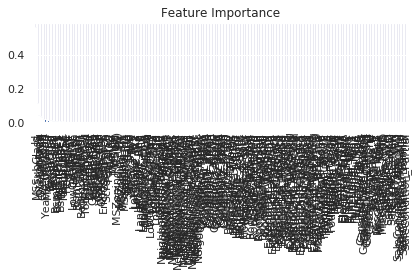

In [126]:
# 畫出feature importance
feat_labels = df.columns  # 取欄位名
importances = model_RFC.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(train_x.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[indices[f]],
                            importances[indices[f]]))
plt.title('Feature Importance')
plt.bar(range(train_x.shape[1]),
       importances[indices],
       align='center')
plt.xticks(range(train_x.shape[1]),
           feat_labels,
           rotation=90)
plt.xlim([-1, train_x.shape[1]])
plt.tight_layout()
plt.show()

In [127]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(model_RFC, threshold=0.0001, prefit=True)  # 特徵重要性門檻值設為0.01
x_selected = sfm.transform(train_x)
print('Number of samples that meet this criterion:',
     x_selected.shape[0])

Number of samples that meet this criterion: 1168


In [128]:
for f in range(x_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[indices[f]],
                            importances[indices[f]]))

 1) OverallQual                    0.562438
 2) GrLivArea                      0.112454
 3) 2ndFlrSF                       0.045780
 4) GarageCars                     0.036902
 5) TotalBsmtSF                    0.028612
 6) BsmtFinSF1                     0.020431
 7) 1stFlrSF                       0.017240
 8) GarageArea                     0.014892
 9) LotArea                        0.014690
10) YearBuilt                      0.014154
11) FullBath                       0.011106
12) BsmtQual                       0.010121
13) MasVnrArea                     0.006688
14) LotFrontage                    0.005634
15) GarageYrBlt                    0.005595
16) WoodDeckSF                     0.005193
17) YearRemodAdd                   0.005097
18) OpenPorchSF                    0.004902
19) Fireplaces                     0.004547
20) BsmtUnfSF                      0.004356
21) OverallCond                    0.004177
22) Id                             0.003399
23) MoSold                      

In [129]:
# 保留重要特徵值欄位
fea_imp = []
for f in range(x_selected.shape[1]):
    fea_imp.append(feat_labels[indices[f]])

#d=set([i.split('_',1)[0] for i in fea_imp])
#fea_imp= list(d)
len(fea_imp)

125

# XGBoosting(資料不進行標準化)

In [130]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
xgb.__version__

'0.80'

In [142]:
%%time
from sklearn.model_selection import GridSearchCV, cross_val_score

#cv_params = {'n_estimators':[100,150,50,30]}
#cv_params = {'max_depth':range(4,9),'min_child_weight':range(1,6)}
#cv_params = {'gamma':[0,0.1,0.2,0.3,0.4,0.5]}
#cv_params = {'subsample':[0.6,0.7,0.4,0.5],'colsample_bytree':[0.6,0.7,0.4,0.5]}
#cv_params = {'reg_alpha':[0,0.05,0.1,1,2,3],'reg_lambda':[0,0.05,0.1,1,2,3]}
#cv_params = {'learning_rate':[0.1,0.15,0.2,0.25,0.3]}
other_params = {'learning_rate':0.15,'n_estimators':100,'max_depth':4,'min_child_weight':3,'seed':0,
              'subsample':0.6,'colsample_bytree':0.6,'gamma':0,'reg_alpha':3,'reg_lambda':0}

model_xgboost = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator = model_xgboost, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=-1)
optimized_GBM.fit(train_x,train_y)
evalute_result = optimized_GBM.grid_scores_
print('each round result:{0}'.format(evalute_result))
print('best params:{0}'.format(optimized_GBM.best_params_))
print('best model score:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    8.8s finished


each round result:[mean: 0.89390, std: 0.03482, params: {'learning_rate': 0.1}, mean: 0.89631, std: 0.02562, params: {'learning_rate': 0.15}, mean: 0.88909, std: 0.02657, params: {'learning_rate': 0.2}, mean: 0.87999, std: 0.03489, params: {'learning_rate': 0.25}, mean: 0.86005, std: 0.03394, params: {'learning_rate': 0.3}]
best params:{'learning_rate': 0.15}
best model score:0.896309429752791
CPU times: user 9.03 s, sys: 11.8 ms, total: 9.05 s
Wall time: 9.22 s


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [275]:
%%time
other_params = {'learning_rate':0.15,'n_estimators':100,'max_depth':4,'min_child_weight':3,'seed':0,
              'subsample':0.6,'colsample_bytree':0.6,'gamma':0,'reg_alpha':3,'reg_lambda':0}

model_xgboost = xgb.XGBRegressor(**other_params)
model_xgboost.fit(train_x,train_y)

CPU times: user 427 ms, sys: 1 µs, total: 427 ms
Wall time: 438 ms


# XGBoosting: 以$R^2$評估回歸結果

In [276]:
predictions = model_xgboost.predict(test_x)
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))

Mean Absolute Error : 16767.153989190923


# XGBoost: 檢視各欄位重要性

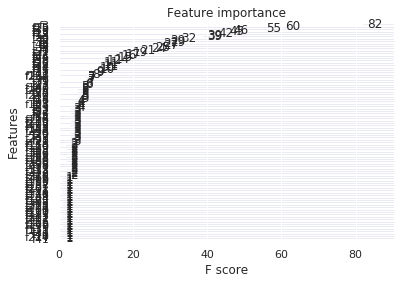

In [147]:
from xgboost import plot_importance

plot_importance(model_xgboost)
plt.show()

# 找出房價離群值

In [148]:
max_stdPrice = np.mean(y) + np.std(y) * 3
min_stdPrice = np.mean(y) - np.std(y) * 3
outlier = []
for i in range(len(y)):
    if y[i] > max_stdPrice:
        outlier += [i]
    elif y[i] < min_stdPrice:
        outlier += [i]

In [149]:
# 刪除離群值資料
df_new = df.drop(outlier, axis = 0)
target_new = target.drop(outlier, axis = 0)

In [150]:
# 選取重要特徵值欄位
df_new = df_new[fea_imp]
dfTest = dfTest[fea_imp]

In [151]:
# 切割訓練 測試資料
from sklearn.model_selection import train_test_split

x2 = df_new.values  ## 原始資料
y2 = target_new.values  ## 原始資料
    
train_x2, test_x2, train_y2, test_y2 = train_test_split(x2, y2, test_size=0.2)

x2.shape

(1438, 125)

In [152]:
assert train_x2.shape[0] == train_y2.shape[0],"error, check my data!"

In [ ]:
# 資料標準化
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#scaler = scaler.fit(train_x2)

#train_x2 = scaler.transform(train_x2)
#test_x2 = scaler.transform(test_x2)

In [ ]:
# 觀察標準化結果
#np.mean(train_x2), np.std(train_x2)  

# Scikit-learn: Ridge Regression

In [153]:
# 建模
from sklearn.linear_model import Ridge

regressor = Ridge(max_iter=1000000)
model_Ridge = regressor.fit(train_x2,train_y2)

In [154]:
# 預測
from sklearn.metrics import r2_score
pred_y2 = model_Ridge.predict(test_x2)
r2_score(test_y2,pred_y2)

0.8625262258617415

In [155]:
# 建模 & 自動調參
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, cross_val_score

al=[0.01,0.1,0.3,0.5,0.8,1.0]
rs=[None,0,1,3]
max_i=[1000000]
kwargs={'alpha':al,'max_iter':max_i,'random_state':rs}

regressor = GridSearchCV(estimator=Ridge(), param_grid=kwargs, n_jobs=-1)  ## 參數：cv=n n則交叉驗證
%time model_Ridge = regressor.fit(train_x2,train_y2)

CPU times: user 702 ms, sys: 7.85 ms, total: 710 ms
Wall time: 728 ms


In [156]:
# 預測
from sklearn.metrics import r2_score
pred_y2 = model_Ridge.predict(test_x2)
r2_score(test_y2,pred_y2)

0.8625262258617415

# Scikit-learn: Lasso Regression

In [157]:
# 建模
from sklearn.linear_model import Lasso

regressor = Lasso(max_iter=1000000)
%time model_Lasso = regressor.fit(train_x2,train_y2)

CPU times: user 35.2 s, sys: 12.6 ms, total: 35.2 s
Wall time: 35.9 s


In [158]:
# 預測
#from sklearn.metrics import r2_score
pred_y2 = model_Lasso.predict(test_x2)
r2_score(test_y2,pred_y2)

0.8207721738756675

In [ ]:
# 建模 & 自動調參
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score

al=[0.1,0.5,1.0]
rs=[None,0,1]
max_i=[1000000]
kwargs={'alpha':al,'max_iter':max_i,'random_state':rs}

regressor = GridSearchCV(estimator=Lasso(), param_grid=kwargs, n_jobs=-1)  ## 參數：cv=n n則交叉驗證
%time model_Lasso = regressor.fit(train_x2,train_y2)

In [ ]:
# 預測
#from sklearn.metrics import r2_score
pred_y2 = model_Lasso.predict(test_x2)
r2_score(test_y2,pred_y2)

# Scikit-learn: Elastic Net Regression

In [159]:
# 建模
from sklearn.linear_model import ElasticNet
regressor = ElasticNet(max_iter=1000000)
%time model_ElasticNet = regressor.fit(train_x2,train_y2)

CPU times: user 1min 20s, sys: 33.5 ms, total: 1min 20s
Wall time: 1min 22s


In [160]:
# 預測
#from sklearn.metrics import r2_score
pred_y2 = model_ElasticNet.predict(test_x2)
r2_score(test_y2,pred_y2)

0.8478722311269774

In [ ]:
# 建模 & 自動調參
#####    吃資源  慎用
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, cross_val_score

al=[0.1,0.5,1.0]
l1=[0,0.5,1.0]
rs=[None,0,3]
max_i=[1000000]
kwargs={'alpha':al,'l1_ratio':l1,'max_iter':max_i,'random_state':rs}

regressor = GridSearchCV(estimator=ElasticNet(), param_grid=kwargs, n_jobs=-1)  ## 參數：cv=n n則交叉驗證
%time model_ElasticNet = regressor.fit(train_x2,train_y2)

In [ ]:
# 預測
#from sklearn.metrics import r2_score
pred_y = model_ElasticNet.predict(test_x2)
r2_score(test_y2,pred_y2)

# Scikit-learn: 樹演算法

In [183]:
# 建模
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(splitter='random',                       # 預設為'best'  #random
                                   max_depth=12,                     # 樹的深度
                                   #min_samples_split=2,             # 分解節點時，最少樣本數 
                                   #min_samples_leaf=1,              # 每個節點最少樣本數
                                   #min_weight_fraction_leaf=0.0, # 每個樣本的權重
                                   #max_features=None,             
                                   random_state=2,
                                   #max_leaf_nodes=None,           # 以雜質相對少的方式種樹，None代表無限制
                                   #min_impurity_decrease=0.0,      # 如果分裂將使雜質減少，則分裂節點
                                   #min_impurity_split=None,          # 樹木早期生長的門檻 以前一個參數為主
                                   presort=False)                         # 是否預先分配數據，加快最佳分裂的發現
%time model_DTR = regressor.fit(train_x2,train_y2)

CPU times: user 10.7 ms, sys: 3.94 ms, total: 14.7 ms
Wall time: 17.7 ms


In [184]:
# 預測
#from sklearn.metrics import r2_score
pred_y2 = model_DTR.predict(test_x2)
r2_score(test_y2,pred_y2)

0.7440321399844778

In [ ]:
# 建模 & 自動調參
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

crit=['entropy']
spli=['best']
m_dep=[5,10,15]
rs=[None,0,1,3]
cl=[None,'balanced']
kwargs={'criterion':crit,'splitter':spli,'max_depth':m_dep,'random_state':rs,'class_weight':cl}

regressor = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=kwargs, n_jobs=-1)  ## 參數：cv=n n則交叉驗證
%time model_DTC = regressor.fit(train_x2,train_y2)

In [ ]:
# 預測
#from sklearn.metrics import r2_score
pred_y2 = model_DTC.predict(test_x2)
r2_score(test_y2,pred_y2)

In [ ]:
# 觀察屬性值重要性，值越大越重要
print(model_DTC.feature_importances_)

# Random Forest regression 隨機森林

In [225]:
# 建模
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=300,    # 樹的數量
                                   criterion='mae',                       # 預設為'mse'  'mae'
                                   #max_depth=None,                   # 預設為None 無限制
                                   #min_samples_split=2,
                                   #min_samples_leaf=1,
                                   #min_weight_fraction_leaf=0.0,
                                   max_features='sqrt',                 # 尋找最佳分割所考慮的功能 'auto' 'sqrt' 'log2' 'None' int float
                                   #max_leaf_nodes=None,
                                   #min_impurity_decrease=0.0,
                                   #min_impurity_split=None,
                                   bootstrap=True,                      # 種樹時是否使用 bootstrap 的樣本
                                   oob_score=True,
                                   n_jobs=-1,                               # 最大工作數 -1代表使用全部的處理器
                                   random_state=2)
                                   #verbose=0,                              # 在擬合和預設時顯示控制詳細程度 (只是顯示步驟而已 對預測確率沒幫助)
                                   #warm_start=False)                   # 設為True時，是以補充隨機森林模型的方式運算
                                   #class_weight=None)                 # 'None' 'balanced' 'balanced_subsample'
%time model_RFR = regressor.fit(train_x2,train_y2)

CPU times: user 5.4 s, sys: 3.8 ms, total: 5.4 s
Wall time: 5.59 s


In [226]:
# 預測
model_RFR.oob_score_

0.8730439150781559

In [ ]:
# 建模 & 自動調參
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

n=[100,150,200]
crit=['gini','entropy']
boo=[True,False]
rs=[None,0,1,3]
kwargs={'n_estimators':n,'criterion':crit,'bootstrap':boo,'random_state':rs}

regressor = GridSearchCV(estimator=RandomForestClassifier(), param_grid=kwargs, n_jobs=-1)  ## 參數：cv=n n則交叉驗證
%time model_RFC = regressor.fit(train_x2,train_y2)

In [ ]:
# 預測
#from sklearn.metrics import r2_score
pred_y2 = model_RFC.predict(test_x2)
%time r2_score(test_y2,pred_y2)

# XGBoosting

In [232]:
%%time
from sklearn.model_selection import GridSearchCV, cross_val_score

#cv_params = {'n_estimators':[100,150,50,30]}
#cv_params = {'max_depth':range(4,9),'min_child_weight':range(1,6)}
#cv_params = {'gamma':[0,0.1,0.2,0.3,0.4,0.5]}
#cv_params = {'subsample':[0.6,0.7,0.4,0.5],'colsample_bytree':[0.6,0.7,0.4,0.5]}
#cv_params = {'reg_alpha':[0,0.05,0.1,1,2,3],'reg_lambda':[0,0.05,0.1,1,2,3]}
#cv_params = {'learning_rate':[0.1,0.15,0.2,0.25,0.3]}
other_params = {'learning_rate':0.15,'n_estimators':100,'max_depth':5,'min_child_weight':4,'seed':0,
              'subsample':0.6,'colsample_bytree':0.6,'gamma':0,'reg_alpha':2,'reg_lambda':0}

model_xgboost = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator = model_xgboost, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=-1)
optimized_GBM.fit(train_x2,train_y2)
evalute_result = optimized_GBM.grid_scores_
print('each round result:{0}'.format(evalute_result))
print('best params:{0}'.format(optimized_GBM.best_params_))
print('best model score:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    6.8s finished


each round result:[mean: 0.89114, std: 0.02616, params: {'learning_rate': 0.1}, mean: 0.89267, std: 0.02833, params: {'learning_rate': 0.15}, mean: 0.87565, std: 0.02519, params: {'learning_rate': 0.2}, mean: 0.86902, std: 0.02310, params: {'learning_rate': 0.25}, mean: 0.85547, std: 0.02711, params: {'learning_rate': 0.3}]
best params:{'learning_rate': 0.15}
best model score:0.8926711634146819
CPU times: user 6.98 s, sys: 7.78 ms, total: 6.98 s
Wall time: 7.14 s


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [277]:
%%time
other_params = {'learning_rate':0.15,'n_estimators':100,'max_depth':5,'min_child_weight':4,'seed':0,
              'subsample':0.6,'colsample_bytree':0.6,'gamma':0,'reg_alpha':2,'reg_lambda':0}

model_xgboost = xgb.XGBRegressor(**other_params)
model_xgboost.fit(train_x2,train_y2, verbose=False)

predictions = model_xgboost.predict(test_x2)
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y2)))

Mean Absolute Error : 16638.035671657984
CPU times: user 325 ms, sys: 33 µs, total: 325 ms
Wall time: 334 ms


# PCA降維後再做XGBoost

In [236]:
from sklearn.decomposition import PCA

In [239]:
%%time
comp=range(90,124)
res=[]
for c in comp:
    pca = PCA(n_components=c)  # 模型會把資料投影至一個方向
    pca = pca.fit(x)  # fit資料，模型會根據資料特性，來找出恰當的方向向量
    unit_vec = pca.components_  # 找到方向向量
    reduced_df = pca.transform(x)
    train_x_PCA, test_x_PCA, train_y_PCA, test_y_PCA = train_test_split(reduced_df, y, test_size=0.2)
    
    # 給予模型參數，告知演算法該如何訓練模型
    other_params = {'learning_rate':0.15,'n_estimators':100,'max_depth':5,'min_child_weight':4,'seed':0,
              'subsample':0.6,'colsample_bytree':0.6,'gamma':0,'reg_alpha':2,'reg_lambda':0}
    model_xgboost = xgb.XGBRegressor(**other_params)
    model_xgboost.fit(train_x_PCA,train_y_PCA)
    pred_y_PCA = model_xgboost.predict(test_x_PCA)
    r2 = r2_score(test_y_PCA,pred_y_PCA)
    res.append((c, r2 , model_xgboost))

CPU times: user 17.7 s, sys: 126 ms, total: 17.8 s
Wall time: 18.4 s


In [240]:
df_res = pd.DataFrame(res, columns=['n_components','r2_score','model'])
df_res

,n_components,r2_score,model
0,90,0.657480,"XGBRegressor(base_score=0.5, booster='gbtree',..."
1,91,0.811253,"XGBRegressor(base_score=0.5, booster='gbtree',..."
2,92,0.869433,"XGBRegressor(base_score=0.5, booster='gbtree',..."
3,93,0.781639,"XGBRegressor(base_score=0.5, booster='gbtree',..."
4,94,0.796437,"XGBRegressor(base_score=0.5, booster='gbtree',..."
5,95,0.771405,"XGBRegressor(base_score=0.5, booster='gbtree',..."
6,96,0.863090,"XGBRegressor(base_score=0.5, booster='gbtree',..."
7,97,0.769516,"XGBRegressor(base_score=0.5, booster='gbtree',..."
8,98,0.772318,"XGBRegressor(base_score=0.5, booster='gbtree',..."
9,99,0.767783,"XGBRegressor(base_score=0.5, booster='gbtree',..."


In [241]:
pca = PCA(n_components=111)  # 模型會把資料投影至一個方向
pca = pca.fit(x)  # fit資料，模型會根據資料特性，來找出恰當的方向向量
unit_vec = pca.components_  # 找到方向向量
reduced_df = pca.transform(x) # 將資料投影到找出來的方向向量上
# reduced_df即為降維後的資料

In [242]:
train_x_PCA, test_x_PCA, train_y_PCA, test_y_PCA = train_test_split(reduced_df, y, test_size=0.2)
# 給予模型參數，告知演算法該如何訓練模型
other_params = {'learning_rate':0.15,'n_estimators':100,'max_depth':5,'min_child_weight':4,'seed':0,
          'subsample':0.6,'colsample_bytree':0.6,'gamma':0,'reg_alpha':2,'reg_lambda':0}
model_xgboost = xgb.XGBRegressor(**other_params)
model_xgboost.fit(train_x_PCA,train_y_PCA)
pred_y_PCA = model_xgboost.predict(test_x_PCA)
r2 = r2_score(test_y_PCA,pred_y_PCA)
res.append((c, r2 , model_xgboost))

# test.csv資料預測

In [243]:
dfTest["GarageYrBlt"] = dfTest["GarageYrBlt"].astype(float)
dfTest["MSSubClass"] = dfTest["MSSubClass"].astype(float)
dfTest["GarageYrBlt"]

0       1961.0
1       1958.0
2       1997.0
3       1998.0
4       1992.0
5       1993.0
6       1992.0
7       1998.0
8       1990.0
9       1970.0
10      1999.0
11      1971.0
12      1997.0
13      1975.0
14      1975.0
15      2009.0
16      2009.0
17      2005.0
18      2005.0
19      2003.0
20      2002.0
21      2006.0
22      2005.0
23      2006.0
24      2004.0
25      2004.0
26      1998.0
27      2005.0
28      2009.0
29      2005.0
         ...  
1429    1925.0
1430    1957.0
1431       0.0
1432       0.0
1433       0.0
1434    2005.0
1435    2004.0
1436    1979.0
1437    1978.0
1438    2001.0
1439    1975.0
1440    1958.0
1441    2000.0
1442    2005.0
1443    2005.0
1444    1951.0
1445    1997.0
1446    1977.0
1447    1968.0
1448    1970.0
1449       0.0
1450    1972.0
1451    1969.0
1452    1970.0
1453       0.0
1454       0.0
1455    1970.0
1456    1960.0
1457       0.0
1458    1993.0
Name: GarageYrBlt, Length: 1459, dtype: float64

In [297]:
dfTest2 = dfTest.values
dfTest2

array([[5.000e+00, 8.960e+02, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [6.000e+00, 1.329e+03, 0.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [5.000e+00, 1.629e+03, 7.010e+02, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [5.000e+00, 1.224e+03, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [5.000e+00, 9.700e+02, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [7.000e+00, 2.000e+03, 1.004e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [299]:
### XGBoost
pred_xgboost = model_xgboost.predict(dfTest2)
pred_xgboost
#test_probs = gbm.predict(xgb.DMatrix(test_feature))

array([132243.12 , 157563.7  , 182543.2  , ..., 148704.03 , 117004.945,
       217191.5  ], dtype=float32)

In [254]:
# Ridge regression
pred_Ridge = model_Ridge.predict(dfTest)
pred_Ridge

array([101301.64712109, 156008.43071347, 165033.25229118, ...,
       165558.30183397, 104200.62433392, 220917.40882966])

In [255]:
# Lasso regression
pred_Lasso = model_Lasso.predict(dfTest)
pred_Lasso

array([101338.9868794 , 155913.00203476, 165912.0312276 , ...,
       165569.19645842, 105555.36176723, 219642.05192999])

In [256]:
# Elastic Net regression
pred_ElasticNet = model_ElasticNet.predict(dfTest)
pred_ElasticNet

array([120061.28861706, 162670.84390157, 176933.73562243, ...,
       166870.61410663, 115892.44236113, 225283.81263144])

In [257]:
# 決策樹
pred_DTR = model_DTR.predict(dfTest)
pred_DTR

array([116803.83333333, 158461.76470588, 174500.        , ...,
       163100.        , 139211.44186047, 222633.88888889])

In [258]:
# 隨機森林
#from sklearn.metrics import r2_score
pred_RFR = model_RFR.predict(dfTest)
pred_RFR

array([126862.86      , 152919.18      , 179084.36      , ...,
       160306.13666667, 116476.23333333, 230244.06333333])

In [300]:
dfTest_old = pd.DataFrame(pd.read_csv("/share/all/test.csv"))
a = pd.DataFrame(dfTest_old['Id'], columns=['Id'])
a['SalePrice'] = pred_xgboost
a.to_csv('/home/bigred/jupyterNotebook/kilio/submission.csv', index=0)

In [ ]:
dfTest.head(5)